In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/efficientnet/tensorflow2/b7-classification/1/saved_model.pb
/kaggle/input/efficientnet/tensorflow2/b7-classification/1/variables/variables.index
/kaggle/input/efficientnet/tensorflow2/b7-classification/1/variables/variables.data-00000-of-00001
/kaggle/input/efficientnet/tensorflow2/b0-classification/1/saved_model.pb
/kaggle/input/efficientnet/tensorflow2/b0-classification/1/variables/variables.index
/kaggle/input/efficientnet/tensorflow2/b0-classification/1/variables/variables.data-00000-of-00001
/kaggle/input/mobilenet-v1/tensorflow2/075-128-classification/2/saved_model.pb
/kaggle/input/mobilenet-v1/tensorflow2/075-128-classification/2/variables/variables.index
/kaggle/input/mobilenet-v1/tensorflow2/075-128-classification/2/variables/variables.data-00000-of-00001
/kaggle/input/severstal-steel-defect-detection/sample_submission.csv
/kaggle/input/severstal-steel-defect-detection/train.csv
/kaggle/input/severstal-steel-defect-detection/train_images/f1bd3a48a.jpg
/kaggle/inp

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.11.0
Hub version: 0.12.0
GPU is available


In [3]:
df_train = pd.read_csv("/kaggle/input/severstal-steel-defect-detection/train.csv")

In [4]:
df_train

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [5]:
from PIL import Image

In [6]:
image1 = Image.open("/kaggle/input/severstal-steel-defect-detection/train_images/000a4bcdd.jpg")
image2 = Image.open("/kaggle/input/severstal-steel-defect-detection/train_images/008621629.jpg")
image3 = Image.open("/kaggle/input/severstal-steel-defect-detection/train_images/005f19695.jpg")

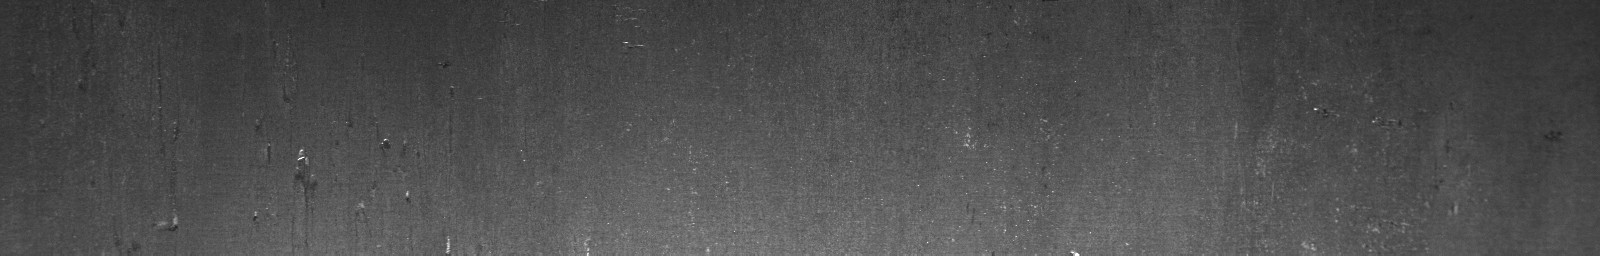

In [7]:
image1

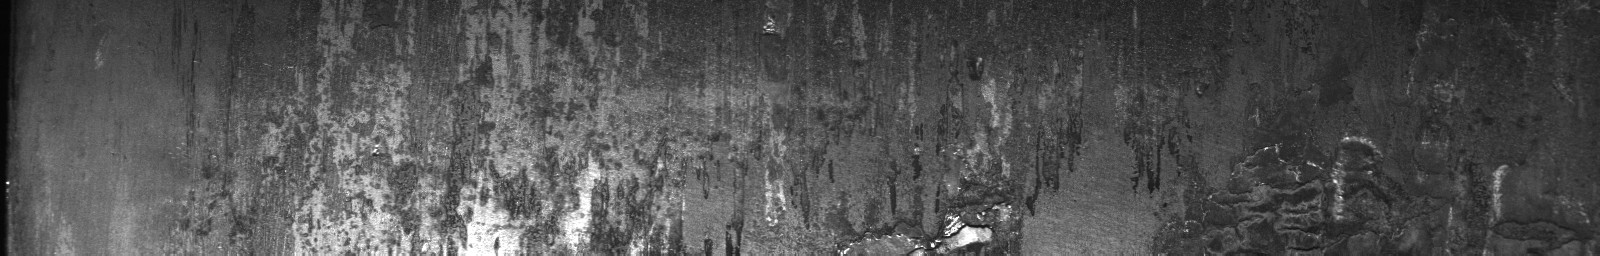

In [8]:
image2

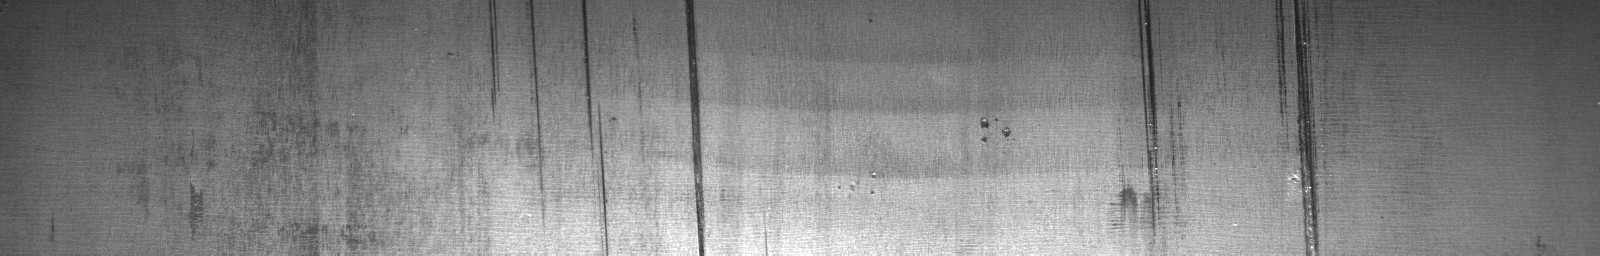

In [9]:
image3

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
data = ImageDataGenerator(rescale = 1/255.0, validation_split = 0.2)

In [12]:
df_train['ClassId'] = df_train['ClassId'].astype(str)

In [13]:
trainData = data.flow_from_dataframe(dataframe=df_train,
                                                directory='/kaggle/input/severstal-steel-defect-detection/train_images',
                                                target_size=(128, 128), x_col='ImageId',
                                                y_col='ClassId', batch_size=16,
                                                class_mode='categorical', subset = "training")

Found 5676 validated image filenames belonging to 4 classes.


In [14]:
testData = data.flow_from_dataframe(dataframe=df_train,
                                                directory='/kaggle/input/severstal-steel-defect-detection/train_images',
                                                target_size=(128, 128), x_col='ImageId',
                                                y_col='ClassId', batch_size=16,
                                                class_mode='categorical', subset = "validation")

Found 1419 validated image filenames belonging to 4 classes.


In [15]:
import keras 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, MaxPooling2D, Dropout

In [16]:
base_model = tf.keras.applications.Xception(input_shape=(128,128,3),include_top=False,weights="imagenet")

83683744/83683744 [==============================] - 1s 0us/step


In [17]:
# Freezing Layers

for layer in base_model.layers[:-5]:
    layer.trainable=False

In [18]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

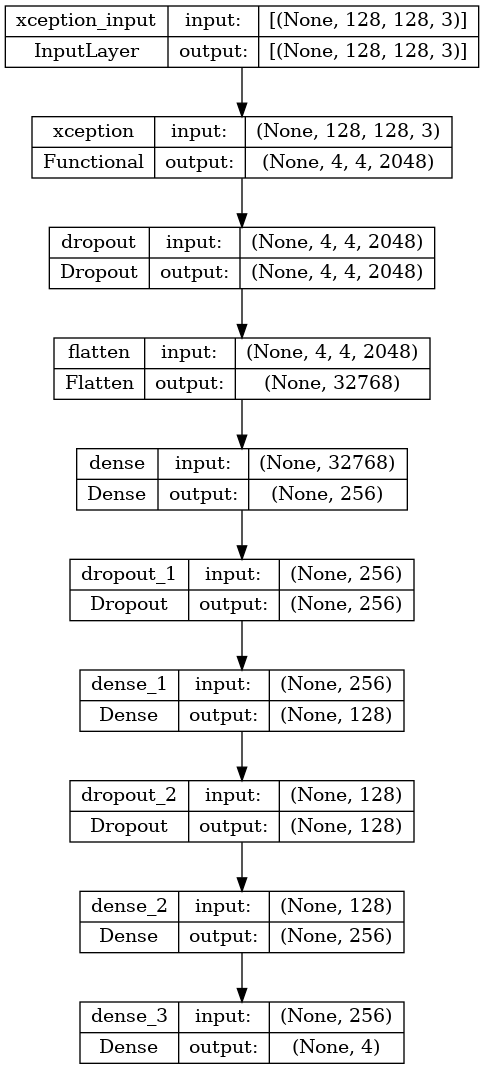

In [19]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [20]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])        # Adam Optimizer help us to find the largest and the smallest value by using gradient descend 

In [21]:
history = model.fit(trainData, steps_per_epoch= len(trainData), epochs = 30, verbose= 1, validation_data = testData, validation_steps = len(testData))

Epoch 1/30


2023-03-13 09:02:21.925343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


355/355 [==============================] - 115s 293ms/step - loss: 0.7062 - accuracy: 0.7363 - val_loss: 0.5777 - val_accuracy: 0.7519
Epoch 2/30
355/355 [==============================] - 56s 158ms/step - loss: 0.5092 - accuracy: 0.7875 - val_loss: 0.5165 - val_accuracy: 0.8020
Epoch 3/30
355/355 [==============================] - 56s 158ms/step - loss: 0.4392 - accuracy: 0.8157 - val_loss: 0.4855 - val_accuracy: 0.8217
Epoch 4/30
355/355 [==============================] - 56s 157ms/step - loss: 0.3949 - accuracy: 0.8302 - val_loss: 0.5117 - val_accuracy: 0.8238
Epoch 5/30
355/355 [==============================] - 56s 158ms/step - loss: 0.3638 - accuracy: 0.8437 - val_loss: 0.4681 - val_accuracy: 0.8097
Epoch 6/30
355/355 [==============================] - 56s 157ms/step - loss: 0.3280 - accuracy: 0.8571 - val_loss: 0.4524 - val_accuracy: 0.8450
Epoch 7/30
355/355 [==============================] - 56s 158ms/step - loss: 0.3024 - accuracy: 0.8650 - val_loss: 0.4691 - val_accuracy: 0.

In [22]:
model_hub = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(128,128,3)),
    hub.KerasLayer('/kaggle/input/mobilenet-v1/tensorflow2/075-128-classification/2',
                  trainable=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])


model_hub.build([None, 128, 128, 3])  # Batch input shape.
model_hub.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              2602745   
                                                                 
 flatten_1 (Flatten)         (None, 1001)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1001)              0         
                                                                 
 dense_4 (Dense)             (None, 4)                 4008      
                                                                 
Total params: 2,606,753
Trainable params: 2,590,337
Non-trainable params: 16,416
_________________________________________________________________


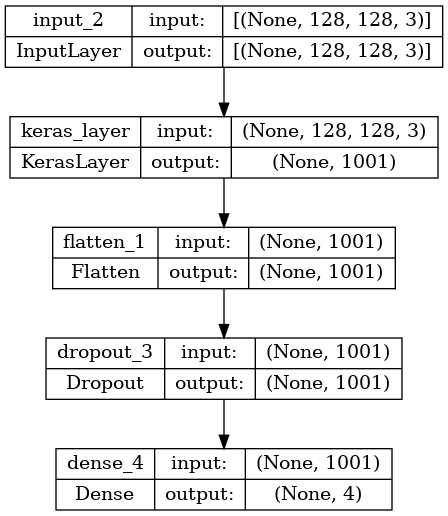

In [23]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model_hub, to_file='convnet2.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet2.png')

In [24]:
model_hub.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])        # Adam Optimizer help us to find the largest and the smallest value by using gradient descend 

In [25]:
history = model_hub.fit(trainData, steps_per_epoch= len(trainData), epochs = 30, verbose= 1, validation_data = testData, validation_steps = len(testData))

Epoch 1/30
355/355 [==============================] - 71s 157ms/step - loss: 1.4267 - accuracy: 0.7512 - val_loss: 0.9466 - val_accuracy: 0.7914
Epoch 2/30
355/355 [==============================] - 56s 159ms/step - loss: 0.6601 - accuracy: 0.8175 - val_loss: 0.6595 - val_accuracy: 0.8386
Epoch 3/30
355/355 [==============================] - 56s 158ms/step - loss: 0.5950 - accuracy: 0.8333 - val_loss: 0.6177 - val_accuracy: 0.8421
Epoch 4/30
355/355 [==============================] - 57s 161ms/step - loss: 0.5560 - accuracy: 0.8428 - val_loss: 0.8286 - val_accuracy: 0.8041
Epoch 5/30
355/355 [==============================] - 57s 160ms/step - loss: 0.5426 - accuracy: 0.8532 - val_loss: 0.5834 - val_accuracy: 0.8562
Epoch 6/30
355/355 [==============================] - 57s 159ms/step - loss: 0.5356 - accuracy: 0.8532 - val_loss: 0.5906 - val_accuracy: 0.8295
Epoch 7/30
355/355 [==============================] - 56s 158ms/step - loss: 0.4921 - accuracy: 0.8687 - val_loss: 0.6698 - val_ac